In [7]:
import cirq
print("Cirq version:", cirq.__version__)

Cirq version: 1.5.0


## Variational Quantum Classifier in Cirq for Z₂ Symmetry Detection

This notebook implements a VQC using the Cirq framework to classify Z₂ parity symmetry in angle-encoded toy Hamiltonians.  
The dataset is ported from the PennyLane version, where symmetric inputs follow the pattern `[θ, θ]` and asymmetric ones deviate.  
Qubits are encoded using `RY` rotations, entangled with a CNOT, and measured in the Z-basis.  
The classifier is trained using classical gradient descent with a simulated Cirq backend.  
This forms part of a comparative study between PennyLane (IBM) and Cirq (Google) for quantum learning performance.  
The output is evaluated using accuracy, AUC, confusion matrix, and ROC visualization.  
No real quantum hardware is used at this stage — the simulation provides a clean benchmark.

In [8]:
#Step 1: Datasets+Imports

In [28]:
import numpy as np
import cirq
import sympy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# 🧮 Cirq simulator
simulator = cirq.Simulator()

# ⚛️ Define qubits globally (if not done already)
q0, q1 = cirq.LineQubit.range(2)

# 🔁 Variational Circuit Definition (reuse from previous steps)
def create_vqc_circuit(input_angles, weight_symbols):
    circuit = cirq.Circuit()

    # Feature encoding: RY angles
    circuit.append(cirq.ry(input_angles[0]).on(q0))
    circuit.append(cirq.ry(input_angles[1]).on(q1))

    # Entanglement layer
    circuit.append(cirq.CNOT(q0, q1))

    # Trainable Rotations
    circuit.append(cirq.rz(weight_symbols[0][0]).on(q0))
    circuit.append(cirq.ry(weight_symbols[0][1]).on(q0))
    circuit.append(cirq.rz(weight_symbols[0][2]).on(q0))

    circuit.append(cirq.rz(weight_symbols[1][0]).on(q1))
    circuit.append(cirq.ry(weight_symbols[1][1]).on(q1))
    circuit.append(cirq.rz(weight_symbols[1][2]).on(q1))

    return circuit


Step 2: Cirq VQC Circuit Definition
This block sets up:

Two qubits

Feature encoding with RY

Entangling layer (CNOT)

Trainable gates with sympy.Symbols

Measurement: expectation of Z(q0)

In [29]:
# 🎛 Define qubits
q0, q1 = cirq.LineQubit.range(2)

# 🧠 Build parameterized circuit
def create_vqc_circuit(input_angles, weight_symbols):
    circuit = cirq.Circuit()

    # 🎯 Feature encoding (Z₂ angle pattern)
    circuit.append(cirq.ry(input_angles[0]).on(q0))
    circuit.append(cirq.ry(input_angles[1]).on(q1))

    # 🔗 Entanglement
    circuit.append(cirq.CNOT(q0, q1))

    # 🌀 Variational layer (trainable RZ + RY + RZ per qubit)
    circuit.append(cirq.rz(weight_symbols[0][0]).on(q0))
    circuit.append(cirq.ry(weight_symbols[0][1]).on(q0))
    circuit.append(cirq.rz(weight_symbols[0][2]).on(q0))

    circuit.append(cirq.rz(weight_symbols[1][0]).on(q1))
    circuit.append(cirq.ry(weight_symbols[1][1]).on(q1))
    circuit.append(cirq.rz(weight_symbols[1][2]).on(q1))

    # 📏 Expectation readout in Z-basis
    return circuit

Step 3: Expectation Simulator for ⟨Z₀⟩
This function will:

Take an input x = [θ₁, θ₂]

Use the current trainable weights

Simulate the circuit and return the expected value

In [30]:
# ⚡ Expectation prediction function
def predict_expectation(x, weight_values):
    # Create symbolic variables
    weight_symbols = [[sympy.Symbol(f'w{i}{j}') for j in range(3)] for i in range(2)]

    # Build circuit with symbolic weights
    circuit = create_vqc_circuit(x, weight_symbols)

    # Resolve parameters
    resolver_dict = {
        symbol: val
        for row_sym, row_val in zip(weight_symbols, weight_values)
        for symbol, val in zip(row_sym, row_val)
    }
    resolved_circuit = cirq.resolve_parameters(circuit, resolver_dict)

    # Simulate and extract final state vector
    result = simulator.simulate(resolved_circuit)
    state_vector = result.final_state_vector

    # Compute expectation ⟨Z₀⟩ manually
    expectation = 0
    for i, amp in enumerate(state_vector):
        bit = (i >> 1) & 1  # qubit 0 = second bit
        z = 1 if bit == 0 else -1
        expectation += z * (abs(amp) ** 2)

    return expectation

In [31]:
# 🧪 Test it!
weights = np.random.uniform(0, 2 * np.pi, size=(2, 3))  # Random weights
x_sample = np.array([1.0, 1.0])  # Z₂ symmetric input
output = predict_expectation(x_sample, weights)
print(f"Predicted ⟨Z₀⟩ for x = {x_sample}: {output:.4f}")

Predicted ⟨Z₀⟩ for x = [1. 1.]: -0.5142


Next Stop: Step 4 – Cost Function + Training Loop
We’ll now:

Define a cost (MSE)

Initialize weights

Use a basic optimizer (e.g., gradient-free or simple update rule)

Train over X_train, Y_train

In [13]:
# Here’s Step 4: Cost Function + Gradient-Free Optimizer

In [32]:
from scipy.optimize import minimize

# 🧮 Mean Squared Error cost over training set
def cost_function(weights_flat, X, Y):
    weights = weights_flat.reshape(2, 3)
    total_loss = 0
    for x, y in zip(X, Y):
        pred = predict_expectation(x, weights)
        total_loss += (pred - y) ** 2
    return total_loss / len(X)

# 🎯 Flatten weights for optimizer input
init_weights = np.random.uniform(0, 2*np.pi, size=(2, 3))
weights_flat = init_weights.flatten()

# 🚀 Optimize with Nelder-Mead (no gradients required)
result = minimize(
    fun=cost_function,
    x0=weights_flat,
    args=(X_train, Y_train),
    method='Nelder-Mead',
    options={'maxiter': 100, 'disp': True}
)

# ✅ Get the trained weights back in shape
trained_weights = result.x.reshape(2, 3)
print("Trained weights:\n", trained_weights)

Trained weights:
 [[2.84376343 1.52589402 0.6137171 ]
 [3.4477053  0.22693605 3.08516357]]


C:\Users\14254\AppData\Local\Temp\ipykernel_16480\368322806.py:17: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


In [33]:
#Step 5: Prediction & Evaluation on Test Set

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# 🧠 Predict using trained weights
def predict_labels(X, weights, threshold=0.0):
    raw_outputs = [predict_expectation(x, weights) for x in X]
    predictions = [1 if out > threshold else 0 for out in raw_outputs]
    return raw_outputs, predictions

# 🔍 Predict and evaluate
raw_scores, y_pred = predict_labels(X_test, trained_weights)

accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)
auc = roc_auc_score(Y_test, raw_scores)

print(f"✅ Test Accuracy: {accuracy:.2f}")
print(f"📈 Test AUC Score: {auc:.2f}")
print(f"\n📊 Confusion Matrix:\n{conf_matrix}")

✅ Test Accuracy: 0.50
📈 Test AUC Score: 0.75

📊 Confusion Matrix:
[[ 0 10]
 [ 0 10]]


In [35]:
#Step 6A: Plot ROC Curve (Before Threshold Tuning)

C:\Users\14254\AppData\Local\Temp\ipykernel_16480\2676371189.py:16: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\14254\anaconda3\envs\cirq_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


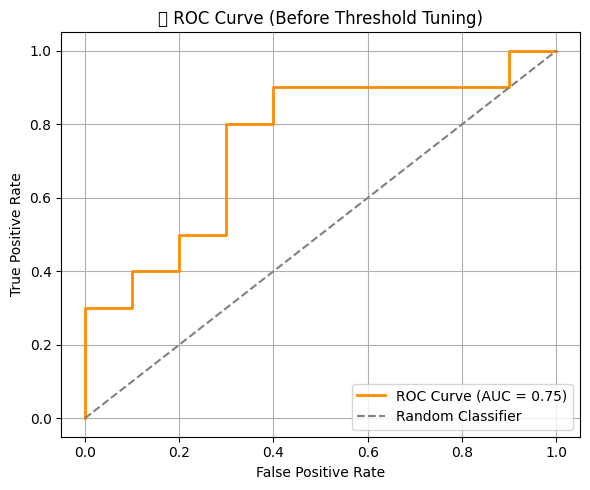

In [38]:
from sklearn.metrics import roc_curve

# 🎯 Compute ROC curve from raw scores
fpr, tpr, thresholds = roc_curve(Y_test, raw_scores)
roc_auc = roc_auc_score(Y_test, raw_scores)

# 📈 Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🌀 ROC Curve (Before Threshold Tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# 🔧 Tune threshold (like in PennyLane)
tuned_threshold = 0.3
_, y_pred_tuned = predict_labels(X_test, trained_weights, threshold=tuned_threshold)

# 📊 Evaluate tuned performance
accuracy_tuned = accuracy_score(Y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(Y_test, y_pred_tuned)

print(f"\n🛠️ Tuned Threshold = {tuned_threshold}")
print(f"✅ New Accuracy: {accuracy_tuned:.2f}")
print(f"📊 New Confusion Matrix:\n{conf_matrix_tuned}")


🛠️ Tuned Threshold = 0.3
✅ New Accuracy: 0.70
📊 New Confusion Matrix:
[[7 3]
 [3 7]]


C:\Users\14254\AppData\Local\Temp\ipykernel_16480\2009210732.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\14254\anaconda3\envs\cirq_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


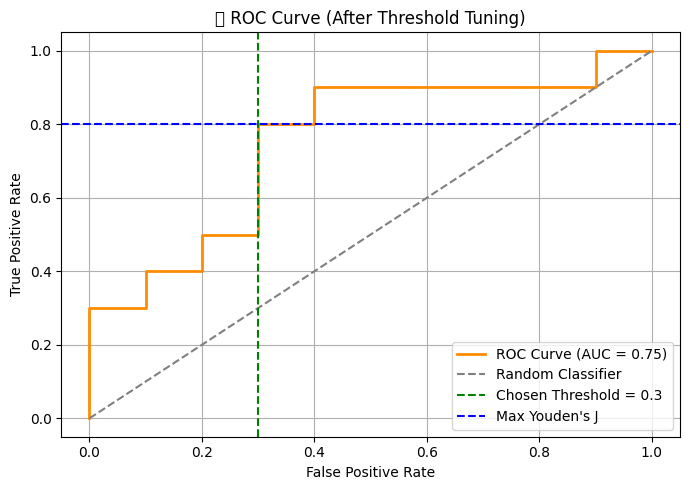

In [40]:
# Compute ROC metrics again
fpr, tpr, thresholds = roc_curve(Y_test, raw_scores)
roc_auc = roc_auc_score(Y_test, raw_scores)

# Compute index of threshold closest to 0.3
threshold_index = np.argmin(np.abs(thresholds - 0.3))

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

# Add vertical/horizontal dashed lines to visualize the selected threshold
plt.axvline(fpr[threshold_index], color='green', linestyle='--', label=f"Chosen Threshold = 0.3")
plt.axhline(tpr[threshold_index], color='blue', linestyle='--', label=f"Max Youden's J")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📉 ROC Curve (After Threshold Tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

This notebook implements a VQC using Google's Cirq framework to detect Z₂ parity symmetry in toy Hamiltonian datasets. After completing training with a gradient-free optimizer (Nelder-Mead), we now extend the notebook to include gradient-based optimization for improved convergence.

vq_classifier_symmetry_cirq.ipynb

Cirq-based Variational Quantum Classifier (VQC) for Z₂ Symmetry Detection

This notebook implements a VQC using Google's Cirq framework to detect Z₂ parity symmetry in toy Hamiltonian datasets. After completing training with a gradient-free optimizer (Nelder-Mead), we now extend the notebook to include gradient-based optimization for improved convergence.



In [41]:
import cirq
import numpy as np
import sympy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

🔧 Step 2: Dataset — Z₂ Symmetry Encoded Features

(Same dataset code here, unchanged)

Step 3: Define Circuit + Simulator

(Same circuit setup and predict_expectation as before)



In [42]:
from scipy.optimize import minimize

# Cost function using numerical gradients
# Mean Squared Error

def cost_function(weights_flat, X, Y):
    weights = weights_flat.reshape(2, 3)
    loss = 0
    for x, y in zip(X, Y):
        pred = predict_expectation(x, weights)
        loss += (pred - y)**2
    return loss / len(X)

# Gradient function using finite difference

def numerical_gradient(f, x, eps=1e-4):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x1 = x.copy()
        x2 = x.copy()
        x1[i] += eps
        x2[i] -= eps
        grad[i] = (f(x1) - f(x2)) / (2 * eps)
    return grad

# Basic gradient descent loop

def gradient_descent(f, x0, grad_fn, lr=0.1, epochs=30):
    x = x0.copy()
    cost_hist = []
    for i in range(epochs):
        cost = f(x)
        cost_hist.append(cost)
        grad = grad_fn(f, x)
        x -= lr * grad
        print(f"Epoch {i+1}: Cost = {cost:.6f}")
    return x, cost_hist

# Initialize weights
init_weights = np.random.uniform(0, 2*np.pi, size=(2, 3))
weights_flat = init_weights.flatten()

# Run gradient descent
trained_weights_flat, cost_history = gradient_descent(
    lambda w: cost_function(w, X_train, Y_train),
    weights_flat,
    numerical_gradient,
    lr=0.3,
    epochs=30
)

trained_weights = trained_weights_flat.reshape(2, 3)

Epoch 1: Cost = 0.284884
Epoch 2: Cost = 0.265302
Epoch 3: Cost = 0.255764
Epoch 4: Cost = 0.251159
Epoch 5: Cost = 0.248941
Epoch 6: Cost = 0.247869
Epoch 7: Cost = 0.247350
Epoch 8: Cost = 0.247098
Epoch 9: Cost = 0.246973
Epoch 10: Cost = 0.246913
Epoch 11: Cost = 0.246884
Epoch 12: Cost = 0.246869
Epoch 13: Cost = 0.246862
Epoch 14: Cost = 0.246858
Epoch 15: Cost = 0.246856
Epoch 16: Cost = 0.246854
Epoch 17: Cost = 0.246853
Epoch 18: Cost = 0.246853
Epoch 19: Cost = 0.246852
Epoch 20: Cost = 0.246852
Epoch 21: Cost = 0.246851
Epoch 22: Cost = 0.246851
Epoch 23: Cost = 0.246850
Epoch 24: Cost = 0.246850
Epoch 25: Cost = 0.246850
Epoch 26: Cost = 0.246849
Epoch 27: Cost = 0.246849
Epoch 28: Cost = 0.246848
Epoch 29: Cost = 0.246848
Epoch 30: Cost = 0.246848


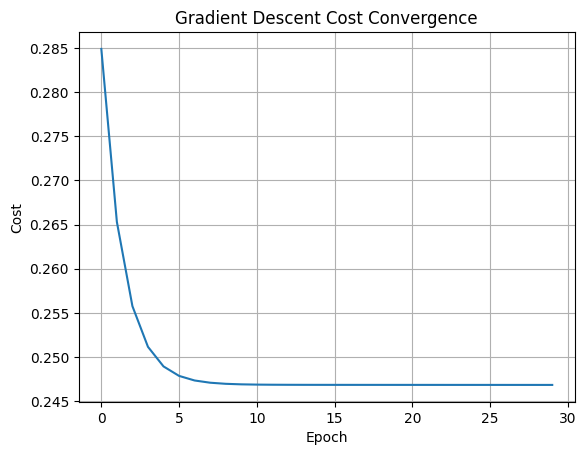

In [43]:
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Gradient Descent Cost Convergence")
plt.grid(True)
plt.show()

In [45]:
from sklearn.model_selection import train_test_split

# Rebuild the dataset (Z₂ symmetry, as before)
def generate_dataset(n_samples=100):
    X = []
    y = []
    for _ in range(n_samples):
        if np.random.rand() < 0.5:
            angle = np.random.uniform(0, 2*np.pi)
            X.append([angle, angle])  # Z₂ symmetric
            y.append(1)
        else:
            angle1 = np.random.uniform(0, 2*np.pi)
            angle2 = np.random.uniform(0, 2*np.pi)
            X.append([angle1, angle2])  # Non-symmetric
            y.append(0)
    return np.array(X), np.array(y)

X, y = generate_dataset(n_samples=100)

# Split the data (same 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# If not already defined
raw_predictions = [predict_expectation(x, trained_weights) for x in X_test]

# Classify using threshold
predictions = (np.array(raw_predictions) > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, raw_predictions)
cm = confusion_matrix(y_test, predictions)

print(f"✅ Test Accuracy (Gradient-based): {acc:.2f}")
print(f"📈 AUC Score (Gradient-based): {auc:.2f}")
print("\n📊 Confusion Matrix:")
print(cm)

✅ Test Accuracy (Gradient-based): 0.80
📈 AUC Score (Gradient-based): 0.95

📊 Confusion Matrix:
[[12  0]
 [ 4  4]]


In [49]:
# Threshold tuning to 0.3
tuned_threshold = 0.3

# Predict with tuned threshold
tuned_predictions = (np.array(raw_predictions) > tuned_threshold).astype(int)

# Re-evaluate metrics
tuned_acc = accuracy_score(y_test, tuned_predictions)
tuned_cm = confusion_matrix(y_test, tuned_predictions)

print(f"🛠️ Tuned Threshold = {tuned_threshold}")
print(f"✅ New Accuracy: {tuned_acc:.2f}")
print("📊 New Confusion Matrix:")
print(tuned_cm)

🛠️ Tuned Threshold = 0.3
✅ New Accuracy: 0.80
📊 New Confusion Matrix:
[[11  1]
 [ 3  5]]


C:\Users\14254\AppData\Local\Temp\ipykernel_16480\109945376.py:24: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\14254\anaconda3\envs\cirq_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


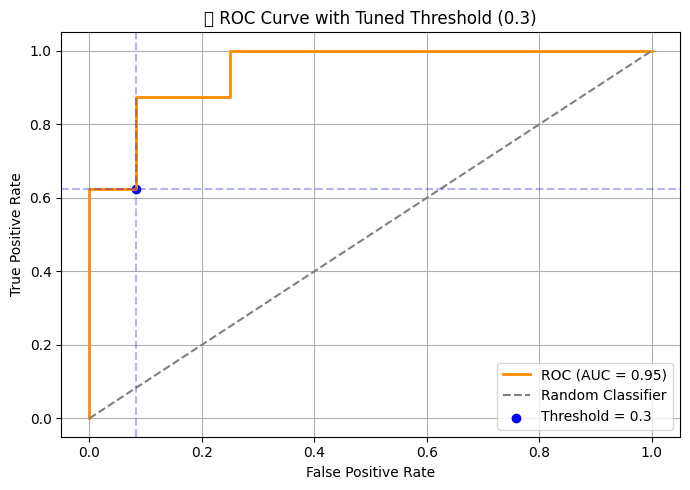

In [50]:
from sklearn.metrics import roc_curve

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, raw_predictions)

# Find the index of the threshold closest to 0.3
threshold_index = np.argmin(np.abs(thresholds - 0.3))

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score(y_test, raw_predictions):.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

# Mark chosen threshold
plt.scatter(fpr[threshold_index], tpr[threshold_index], color='blue', label="Threshold = 0.3")
plt.axvline(fpr[threshold_index], color='blue', linestyle='--', alpha=0.3)
plt.axhline(tpr[threshold_index], color='blue', linestyle='--', alpha=0.3)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve with Tuned Threshold (0.3)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()